In [18]:
import nistats
import nibabel as nib
import nilearn
from nilearn import image
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl

%matplotlib inline

## Load first-levels

In [19]:
onset_shift = 0
first_level_models = []
print('loading...', end='')
for sub in np.arange(1,34):
    if sub == 23:
        continue   # doesn't exist
    fn = f'./models_sm_stc/sub-{sub}_shift-{onset_shift}_glm.pkl'
    if os.path.exists(fn):
        print('.', end='')
        with open(fn, 'rb') as f:
            model = pkl.load(f)
        first_level_models.append(model)
print('done, loaded {} models'.format(len(first_level_models)))

loading...................................done, loaded 32 models


## second-level, 5mm smoothing

In [20]:
second_level_model = SecondLevelModel(smoothing_fwhm=5)  # 5mm, cf De Hollander 2017
second_level_model = second_level_model.fit(first_level_models)
z1 = second_level_model.compute_contrast(first_level_contrast='response_left - response_right')

3.367255061957768


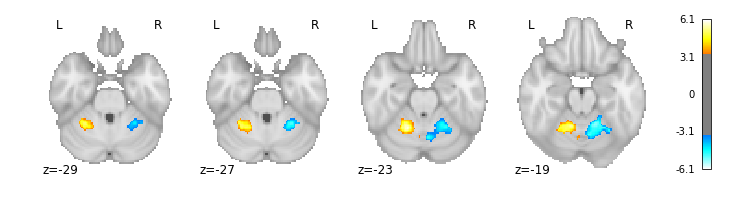

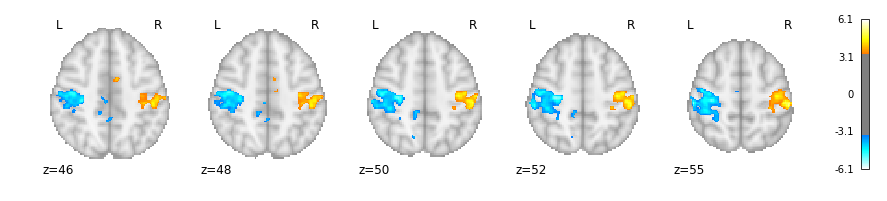

In [21]:
_, threshold = map_threshold(z1, level=0.05, height_control='fdr')
print(threshold)

plot_stat_map(z1, display_mode='z', threshold=threshold, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z1, display_mode='z', threshold=threshold, cut_coords=[46, 48, 50, 52, 55])

## second level, less smoothing

In [22]:
second_level_model = SecondLevelModel(smoothing_fwhm=1.5)     # 1 voxel
second_level_model = second_level_model.fit(first_level_models)
z2 = second_level_model.compute_contrast(first_level_contrast='response_left - response_right')

4.572694856149148


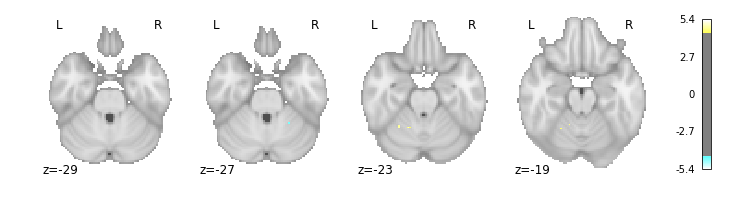

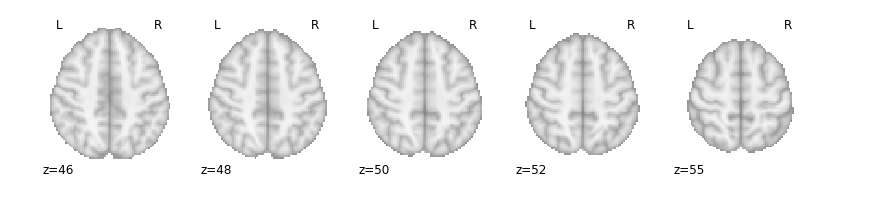

In [23]:
_, threshold = map_threshold(z2, level=0.05, height_control='fdr')
print(threshold)

plot_stat_map(z2, display_mode='z', threshold=threshold, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z2, display_mode='z', threshold=threshold, cut_coords=[46, 48, 50, 52, 55])

#### Unfornately the FDR-corrected becomes to high. If we're more liberal, we can find something in line with expectations

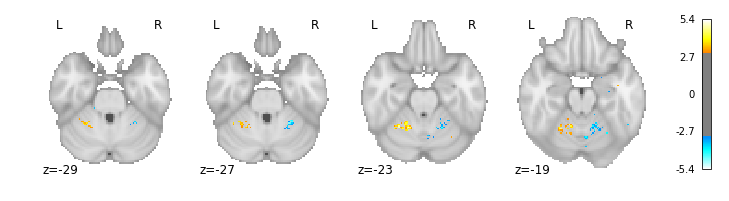

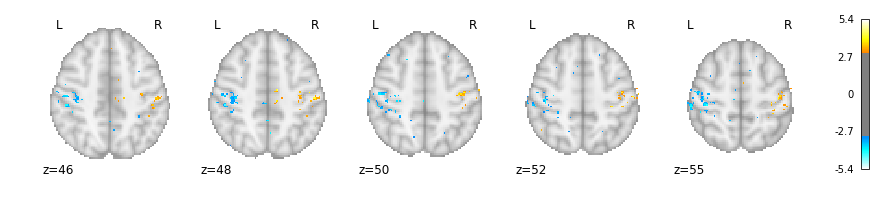

In [24]:
plot_stat_map(z2, display_mode='z', threshold=3.1, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z2, display_mode='z', threshold=3.1, cut_coords=[46, 48, 50, 52, 55])

## second level, no smoothing, liberal threshold

In [25]:
second_level_model = SecondLevelModel(smoothing_fwhm=None)
second_level_model = second_level_model.fit(first_level_models)
z3 = second_level_model.compute_contrast(first_level_contrast='response_left - response_right')

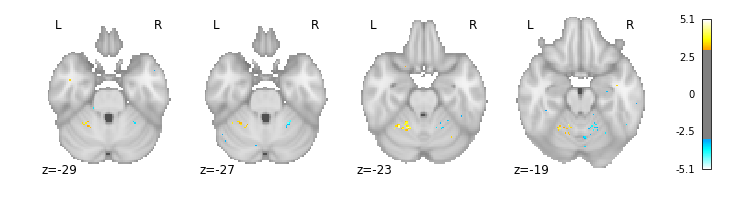

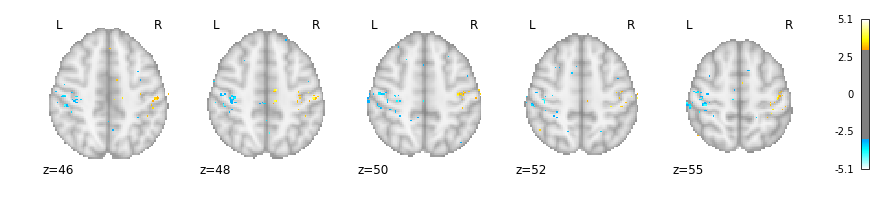

In [26]:
plot_stat_map(z3, display_mode='z', threshold=3.1, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z3, display_mode='z', threshold=3.1, cut_coords=[46, 48, 50, 52, 55])

# Overall: The data seem in line with expectations, finding 'activated' voxels in motor regions in M1 and ipsilateral in cerebellum

### Can we find a difference in overall results between sites?

## Second level, Leipzig only

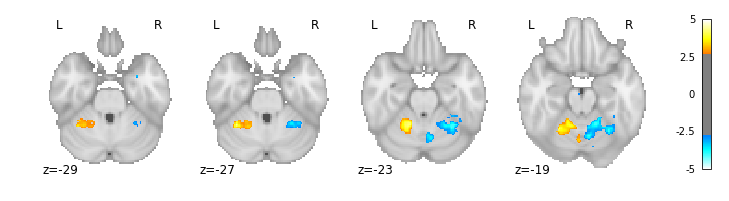

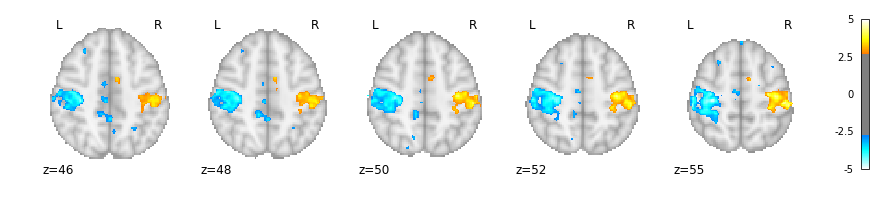

In [27]:
second_level_model_leipzig = SecondLevelModel(smoothing_fwhm=5)  # 5mm, cf De Hollander 2017
second_level_model_leipzig = second_level_model_leipzig.fit(first_level_models[:20])  # 1-19 are Leipzig, 20-34 are Amsterdam [23 misses]
z_leipzig = second_level_model_leipzig.compute_contrast(first_level_contrast='response_left - response_right')

plot_stat_map(z_leipzig, display_mode='z', threshold=2.8, vmax=5, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z_leipzig, display_mode='z', threshold=2.8, vmax=5, cut_coords=[46, 48, 50, 52, 55])

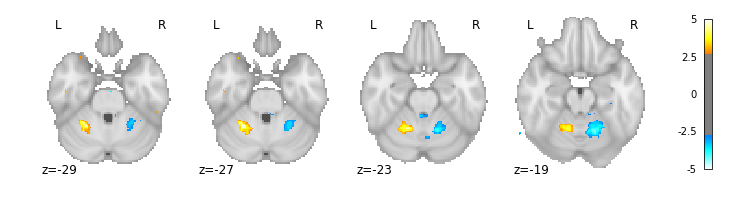

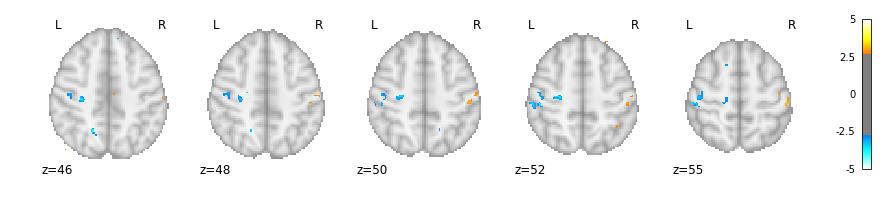

In [28]:
second_level_model_amsterdam = SecondLevelModel(smoothing_fwhm=5)  # 5mm, cf De Hollander 2017
second_level_model_amsterdam = second_level_model_amsterdam.fit(first_level_models[20:])
z_amsterdam = second_level_model_amsterdam.compute_contrast(first_level_contrast='response_left - response_right')

plot_stat_map(z_amsterdam, display_mode='z', threshold=2.8, vmax=5, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z_amsterdam, display_mode='z', threshold=2.8, vmax=5, cut_coords=[46, 48, 50, 52, 55])

#### Eye-balling, there seems to be a small difference, with a bit more focal clusters in the Amsterdam data, and a bit larger clusters in the Leipzig data ('inherent' smoothness?). However, there's also power differences since the Leipzig data consists of 19 subjects vs 14 in  Amsterdam

Let's look at mean first-level z-scores instead, as a measure of (within-subject) "signal-to-noise" values. 

Analyses below makes use of unsmoothed data

In [29]:
first_level_zscores = [x.compute_contrast('response_left - response_right', output_type='z_score') for x in first_level_models]

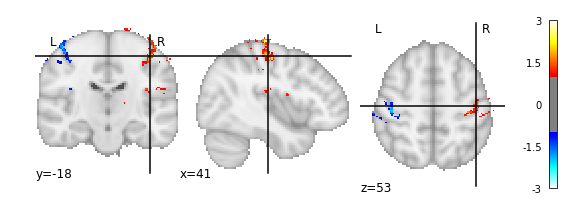

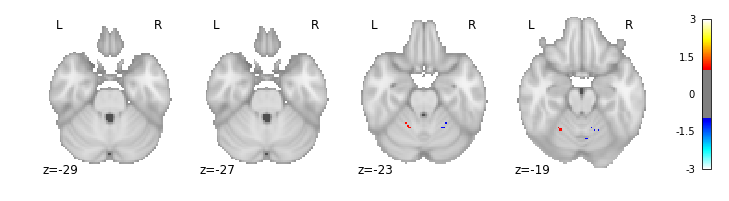

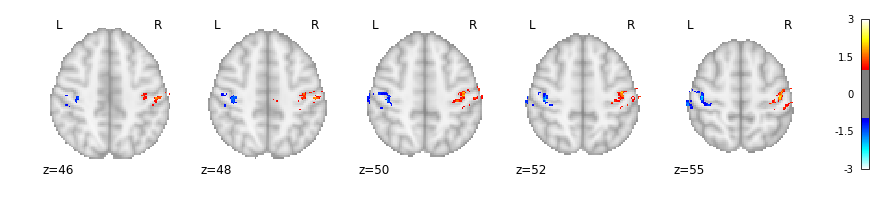

In [30]:
mean_zscore = nilearn.image.mean_img(nilearn.image.concat_imgs(first_level_zscores))
plot_stat_map(mean_zscore, threshold=1, vmax=3)
plot_stat_map(mean_zscore, display_mode='z', threshold=1, vmax=3, cut_coords=[-29, -27, -23, -19])
plot_stat_map(mean_zscore, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55])

## the threshold is abritrary here, only used for visualization purposes

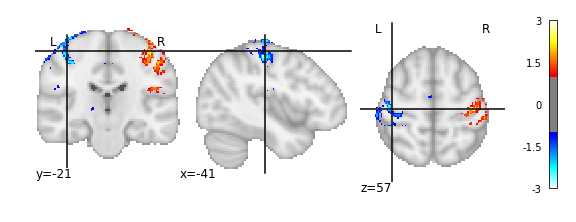

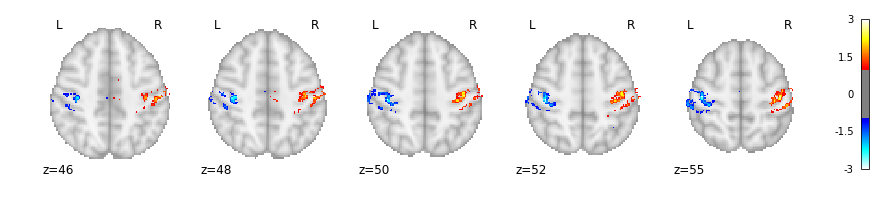

In [31]:
mean_zscore_leipzig = nilearn.image.mean_img(nilearn.image.concat_imgs(first_level_zscores[:20]))
plot_stat_map(mean_zscore_leipzig, threshold=1, vmax=3)
plot_stat_map(mean_zscore_leipzig, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55])

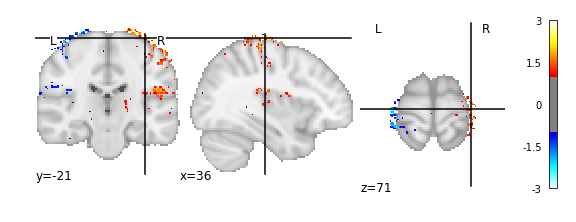

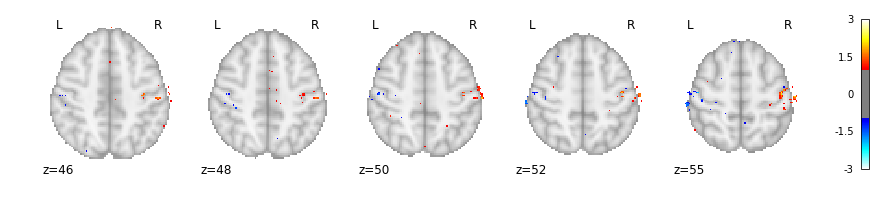

In [32]:
mean_zscore_amsterdam = nilearn.image.mean_img(nilearn.image.concat_imgs(first_level_zscores[20:]))
plot_stat_map(mean_zscore_amsterdam, threshold=1, vmax=3)
plot_stat_map(mean_zscore_amsterdam, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55])

Again, the Amsterdam data seems a bit less smooth (which is good) compared to the Leipzig data. But the results are highly comparable I think.

Taken together, the simple `left<right` clusters seem in line with expectations and, eye-balling, I don't see a reason to believe there's anything wrong with the event onsets as recorded?

## Compare onsets, see if z-values increase or decrease

loading................................done
loading................................done
loadingdone


TypeError: Cannot concatenate empty objects

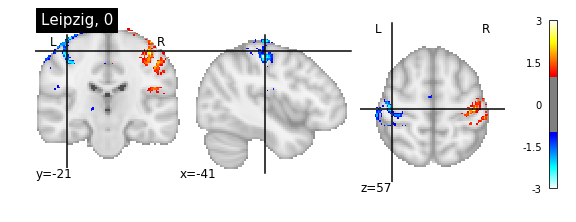

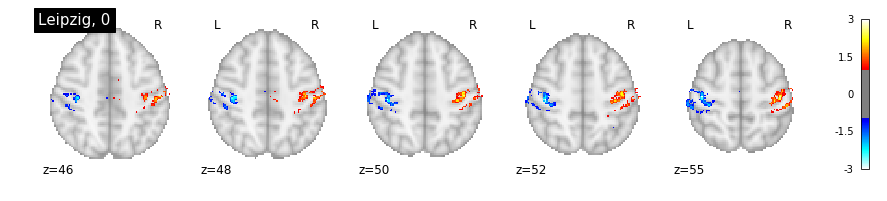

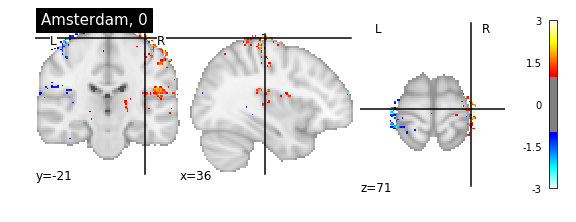

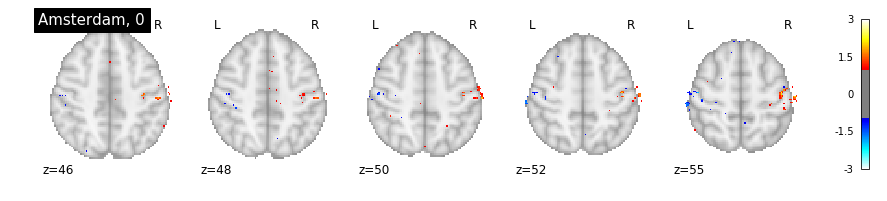

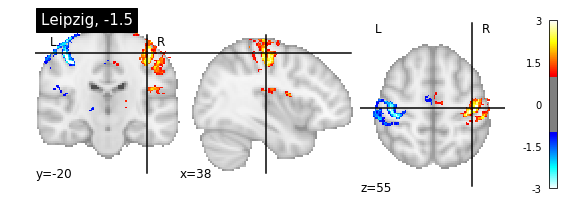

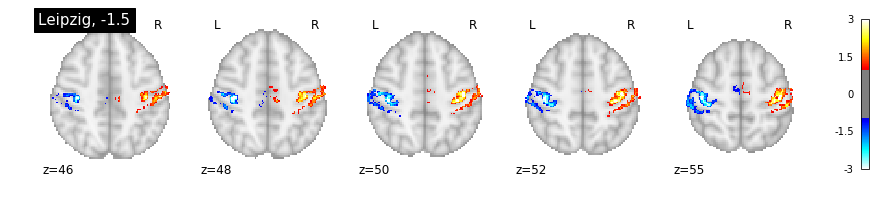

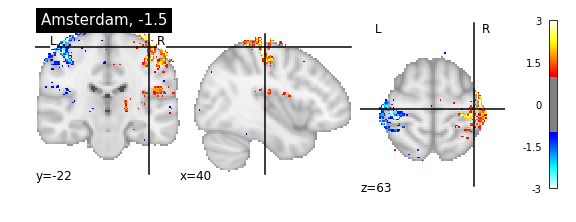

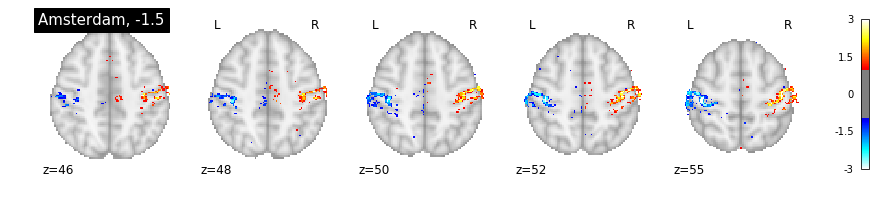

In [42]:
for onset_shift in [0, -1.5, 1.5, -3]:
    first_level_models = []
    print('loading', end='')
    for sub in np.arange(1,34):
        if sub == 23:
            continue  # doesn't exist
        fn = f'./models_sm_stc/sub-{sub}_shift-{onset_shift}_glm.pkl'
        if os.path.exists(fn):
            print('.', end='')
            with open(fn, 'rb') as f:
                model = pkl.load(f)
            first_level_models.append(model)
    print('done')

    first_level_zscores = [x.compute_contrast('response_left - response_right', output_type='z_score') for x in first_level_models]

    ## Leipzig
    mean_zscore_leipzig = nilearn.image.mean_img(nilearn.image.concat_imgs(first_level_zscores[:20]))
    plot_stat_map(mean_zscore_leipzig, threshold=1, vmax=3, title='Leipzig, {}'.format(onset_shift))
    plot_stat_map(mean_zscore_leipzig, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55], title='Leipzig, {}'.format(onset_shift))

    ## Amsterdam
    mean_zscore_amsterdam = nilearn.image.mean_img(nilearn.image.concat_imgs(first_level_zscores[20:]))
    plot_stat_map(mean_zscore_amsterdam, threshold=1, vmax=3, title='Amsterdam, {}'.format(onset_shift))
    plot_stat_map(mean_zscore_amsterdam, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55], title='Amsterdam, {}'.format(onset_shift))

In [40]:
nib.save(mean_zscore_amsterdam, 'tmp_z_scores_ams.nii.gz')

In [ ]:
## Ok so -3 works best, even though -1.5 is "theoretically correct"

## can we find slice timing info in the nifti header?


In [ ]:
print(nib.load('./derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_space-T1w_desc-preproc_bold.nii.gz').header)
print(nib.load('./derivatives/ds-02/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_bold_space-T1w_preproc.nii.gz').header)

## individual z-maps?

In [43]:
onset_shift = 0
first_level_models = []
print('loading', end='')
for sub in np.arange(1,34):
    if sub == 23:
        continue  # doesn't exist
    fn = f'./models_sm_stc/sub-{sub}_shift-{onset_shift}_glm.pkl'
    if os.path.exists(fn):
        print('.', end='')
        with open(fn, 'rb') as f:
            model = pkl.load(f)
        first_level_models.append(model)
print('done')

first_level_zscores = [x.compute_contrast('response_left - response_right', output_type='z_score') for x in first_level_models]

for sub_n, first_level_zscore in enumerate(first_level_zscores):
    plot_stat_map(first_level_zscore, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55], title='Subject {}'.format(sub_n))
    plot_stat_map(image.smooth_img(first_level_zscore, 5), display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55], title='Subject {}, FWHM=5mm smoothed'.format(sub_n))

loading...............

KeyboardInterrupt: 

In [ ]:
onset_shift = -1.5
first_level_models = []
print('loading', end='')
for sub in np.arange(1,34):
    if sub == 23:
        continue  # doesn't exist
    fn = f'./models_sm_stc/sub-{sub}_shift-{onset_shift}_glm.pkl'
    print('.', end='')
    with open(fn, 'rb') as f:
        model = pkl.load(f)
    first_level_models.append(model)
print('done')

first_level_zscores = [x.compute_contrast('response_left - response_right', output_type='z_score') for x in first_level_models]

for sub_n, first_level_zscore in enumerate(first_level_zscores):
    plot_stat_map(first_level_zscore, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55], title='Subject {}'.format(sub_n))
    plot_stat_map(image.smooth_img(first_level_zscore, 5), display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55], title='Subject {}, FWHM=5mm smoothed'.format(sub_n))


## what about easy vs hard?

In [44]:
first_level_models = []
onset_shift = 0
print('loading', end='')
for sub in np.arange(1,34):
    fn = f'./models_sm_stc/sub-{sub}_shift-{onset_shift}_glm.pkl'
    if os.path.exists(fn):
        print('.', end='')
        with open(fn, 'rb') as f:
            model = pkl.load(f)
        first_level_models.append(model)
print('done')



# first_level_zscores = [x.compute_contrast('hard - easy', output_type='z_score') for x in first_level_models]

# ## Leipzig
# mean_zscore_leipzig = nilearn.image.mean_img(nilearn.image.concat_imgs(first_level_zscores[:20]))
# plot_stat_map(mean_zscore_leipzig, threshold=1, vmax=3, title='Leipzig, {}'.format(onset_shift))
# plot_stat_map(mean_zscore_leipzig, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55], title='Leipzig, {}'.format(onset_shift))

# ## Amsterdam
# mean_zscore_amsterdam = nilearn.image.mean_img(nilearn.image.concat_imgs(first_level_zscores[20:]))
# plot_stat_map(mean_zscore_amsterdam, threshold=1, vmax=3, title='Amsterdam, {}'.format(onset_shift))
# plot_stat_map(mean_zscore_amsterdam, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55], title='Amsterdam, {}'.format(onset_shift))

loading................................done


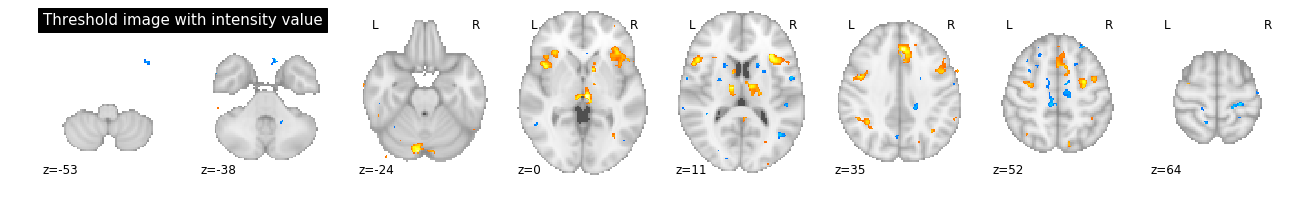

In [45]:
second_level_model_all = SecondLevelModel(smoothing_fwhm=5)  # 5mm, cf De Hollander 2017
second_level_model_all = second_level_model_all.fit(first_level_models)
z_all = second_level_model_all.compute_contrast(first_level_contrast='hard - easy')

threshold_value_img = image.threshold_img(z_all, threshold=2.5)
plotting.plot_stat_map(threshold_value_img, display_mode='z', cut_coords=8,
                       title='Threshold image with intensity value', colorbar=False)

In [46]:
from nilearn.regions import connected_regions
regions_value_img, index = connected_regions(threshold_value_img, min_region_size=30)

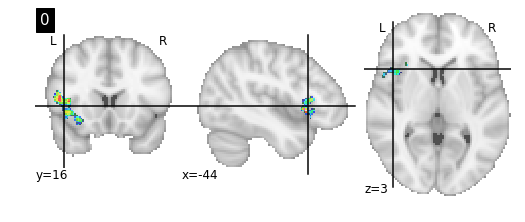

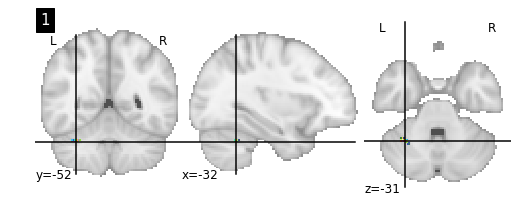

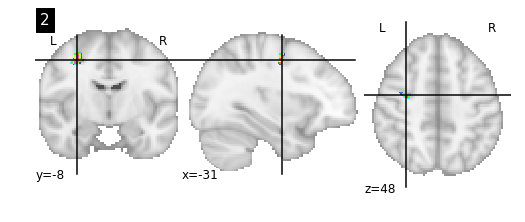

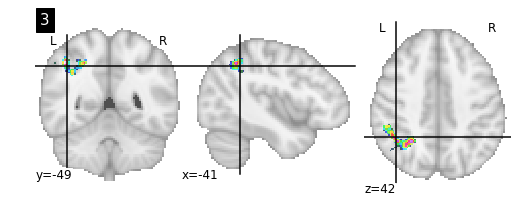

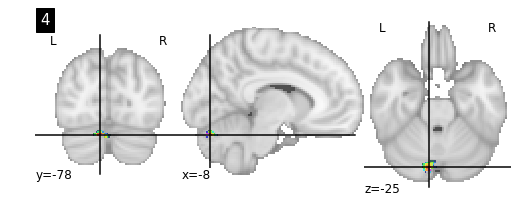

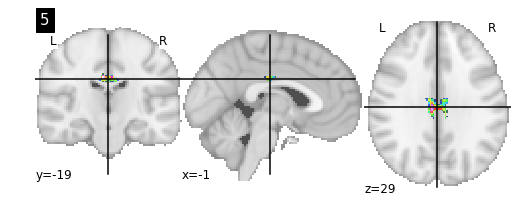

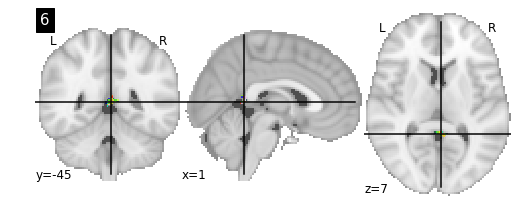

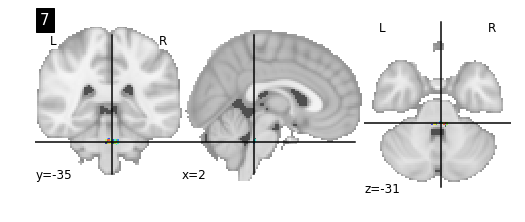

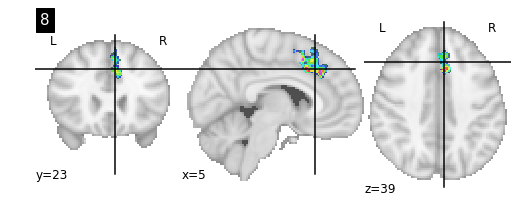

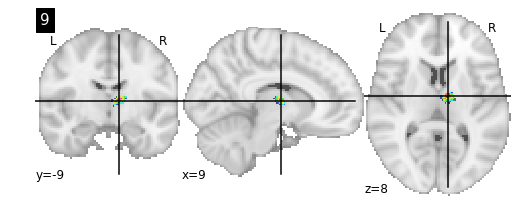

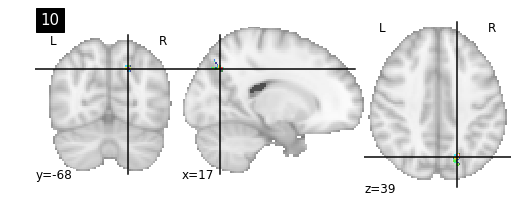

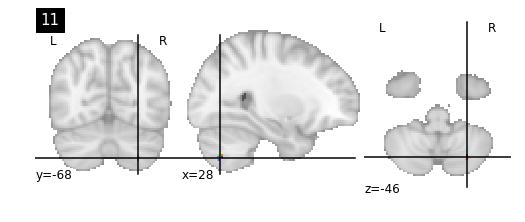

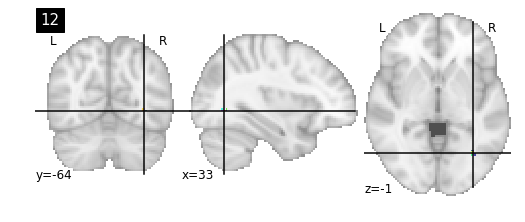

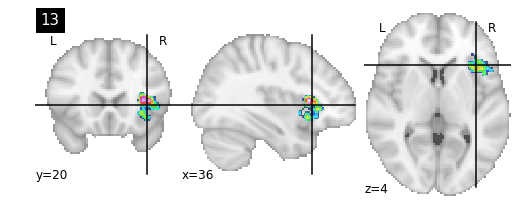

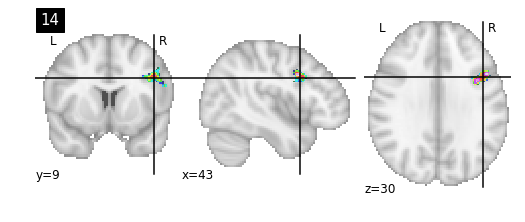

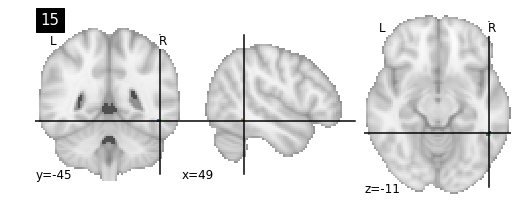

In [47]:
for i in range(regions_value_img.shape[3]):
    plotting.plot_roi(image.index_img(regions_value_img,i), title=i)

## Let's do these ROIS:


In [48]:
rois = {3: 'parietal',    # COM: z = 42
        4: 'cerebellar',  # COM: z = -25
        5: 'cc',          # COM: z = 29
        8: 'ACC',         # COM: Z = 39
        9: 'midbrain',    # COM: z = 8
        13: 'insula',     # COM: z = 4
        14: 'rifg'}       # COM: z = 30

In [50]:
for roi_num, roi_name in rois.items():
    nib.save(image.index_img(regions_value_img, roi_num), './masks_func/space-MNI152NLin2009cAsym_label-{}.nii.gz'.format(roi_name))